In [1]:
import os

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns
import gpytorch
import torch

from REStats.utils import load_SCADA, filter_outliers
from REStats.plots import save_figs
from REStats.models import calc_iec_power_curve, power_curve

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2020)

In [5]:
cut_out = 17.5 # TODO: infer?
wt_train = wt[["wind_speed", "power"]]
wt_train = wt_train.resample("H").mean()
wt_train = wt_train[wt_train.wind_speed <= cut_out]

wt_filtered = filter_outliers(wt_train)

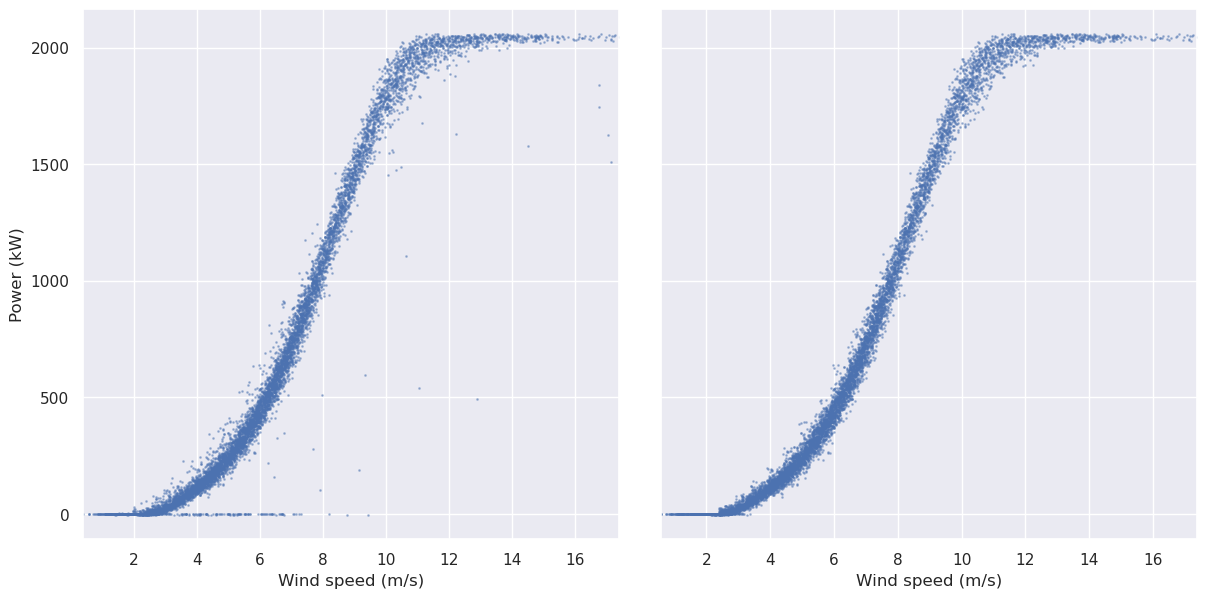

In [6]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].scatter(wt_train.wind_speed, wt_train.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [7]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_filtered, stratify=bins, train_size=400, test_size=400, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train

,wind_speed,power,power_std
Date,,,
2020-10-29 14:00:00,10.551476,1780.762233,1.577944
2020-10-16 15:00:00,4.166823,126.054918,-0.914641
2020-06-20 02:00:00,6.075461,384.976530,-0.524612
2020-04-14 23:00:00,5.450504,318.980622,-0.624026
2020-06-24 02:00:00,6.149067,407.390644,-0.490848
...,...,...,...
2020-02-08 06:00:00,4.997415,239.079779,-0.744385
2020-09-05 06:00:00,5.670878,388.944689,-0.518635
2020-05-18 05:00:00,7.549004,954.782476,0.333721


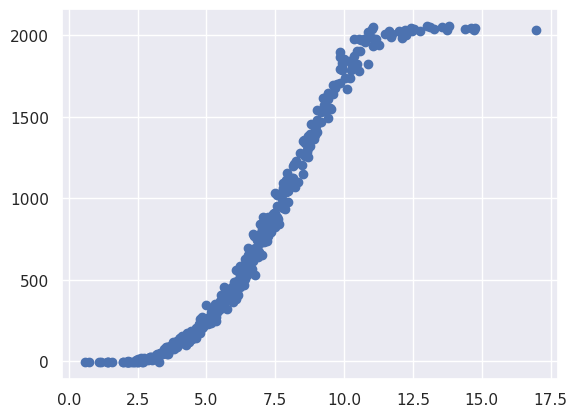

In [8]:
plt.scatter(train.wind_speed, train.power)

## IEC Method

In [9]:
iec_pc = calc_iec_power_curve(wt_filtered, cut_out)
iec_pc.tail()

,wind_speed,power
wind_speed,,
"(14.5, 15.0]",14.761471,2044.158234
"(15.0, 15.5]",15.206849,2042.771261
"(15.5, 16.0]",15.750089,2040.320594
"(16.0, 16.5]",16.227438,2042.865202
"(16.5, 17.0]",16.750873,2043.011841


In [10]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in test.wind_speed]

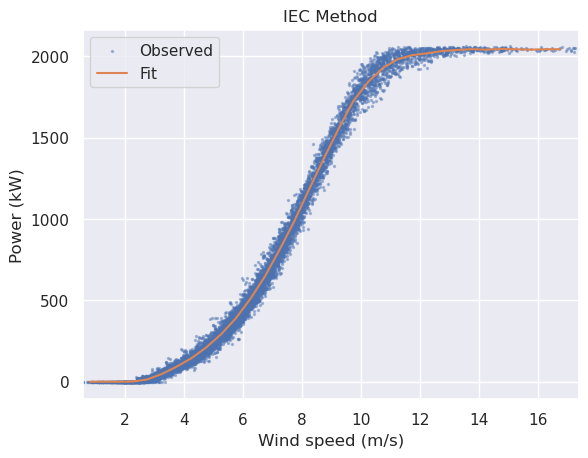

In [11]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(wt_filtered.wind_speed, wt_filtered.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [12]:
rmse = mean_squared_error(iec_pred, test.power, squared=False)

print(f"IEC Test RMSE: {rmse} kW")

IEC Test RMSE: 54.826778913768464 kW


## `gpytorch`

In [13]:
X_train = torch.tensor(train.wind_speed)
y_train = torch.tensor(train.power_std)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.830   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.790   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.750   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.709   lengthscale: 0.854   noise: 0.554
Iter 5/100 - Loss: 0.669   lengthscale: 0.912   noise: 0.513
Iter 6/100 - Loss: 0.627   lengthscale: 0.972   noise: 0.474
Iter 7/100 - Loss: 0.586   lengthscale: 1.034   noise: 0.437
Iter 8/100 - Loss: 0.543   lengthscale: 1.098   noise: 0.403
Iter 9/100 - Loss: 0.501   lengthscale: 1.164   noise: 0.370
Iter 10/100 - Loss: 0.457   lengthscale: 1.231   noise: 0.340
Iter 11/100 - Loss: 0.414   lengthscale: 1.299   noise: 0.312
Iter 12/100 - Loss: 0.369   lengthscale: 1.369   noise: 0.286
Iter 13/100 - Loss: 0.325   lengthscale: 1.439   noise: 0.261
Iter 14/100 - Loss: 0.279   lengthscale: 1.510   noise: 0.239
Iter 15/100 - Loss: 0.234   lengthscale: 1.582   noise: 0.218
Iter 16/100 - Loss: 0.188   lengthscale: 1.654   noise: 0.198
Iter 17/100 - Los

In [14]:
fit_x = torch.linspace(0, cut_out+1.5, 200)
fit_pred = power_curve.predict(model, likelihood, fit_x)

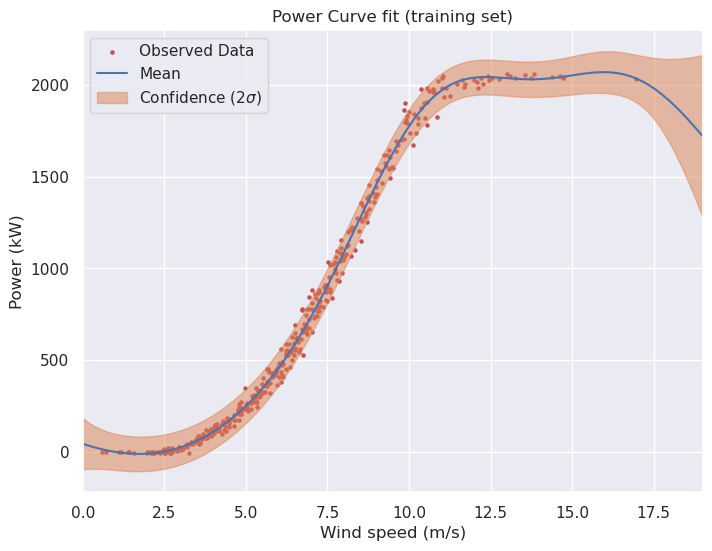

In [15]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve fit (training set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")

    # Get upper and lower confidence bounds
    lower, upper = fit_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train.wind_speed, train.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(fit_x.numpy(), fit_pred.mean.numpy() * train.power.std() + train.power.mean(), color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(fit_x.numpy(), lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])

In [16]:
test_sort = test.sort_values("wind_speed")
X_test_torch = torch.tensor(test_sort.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

In [17]:
test_pred_tf = test_pred.mean.numpy() * train.power.std() + train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse} kW")

Test RMSE: 42.779929698414506 kW


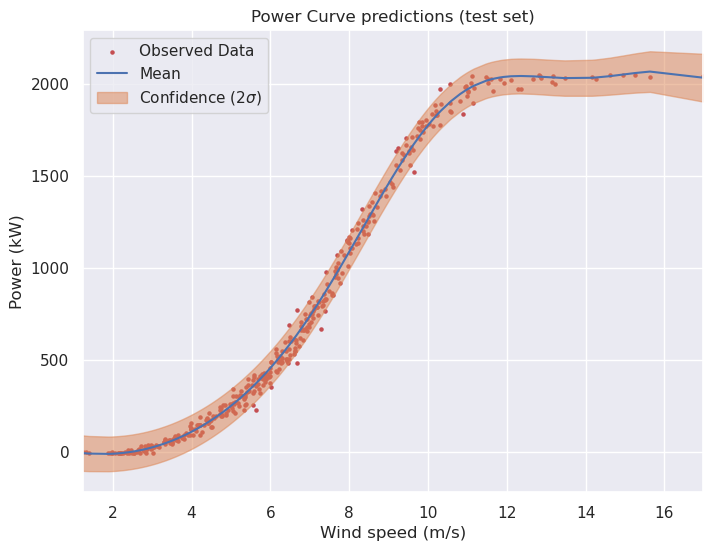

In [18]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve predictions (test set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")
    

    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(test.wind_speed, test.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(X_test_torch.numpy(), test_pred_tf, color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(X_test_torch.numpy().flatten(), lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])

In [19]:
if SAVE_FIGS:
    save_figs(figs)